In [6]:
import altair as alt
import numpy as np
import pandas as pd
import glob
import os
import base64
import random
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import io


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [3]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config

In [4]:
#These are functions for displaying thumbnails of the micrographs in pandas

pd.set_option('display.max_colwidth', None)


def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'


### You can get the model from my s3 bucket.  This does take a while to download as it is ~5GB.

In [5]:
#download for the model

file_name = "UHCS_Microstructure_Model.keras"

s3 = boto3.resource('s3',config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket("robertgwolf-tdi-capstone-project")
bucket.download_file(file_name,file_name)

### Run the column transformer so the output data can be transformed

In [7]:
col_transformer_data = pd.read_csv('col_transformer_data.csv')

In [8]:
ColScaler = ColumnTransformer([('scaler',StandardScaler(),['inverse_anneal_temperature_Kelvin',
                                                                   'log_time',
                                                                  ])])

ColScaler.set_output(transform ='pandas')

ColScaler.fit(col_transformer_data)


ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['inverse_anneal_temperature_Kelvin',
                                  'log_time'])])

### Building the sample dataframe to run the model on from images in the sample_micrographs folder

In [9]:
sample_images_path = list(glob.glob('sample_micrographs/*'))
sample_images = [os.path.basename(file) for file in sample_images_path ]

samples_df = pd.DataFrame({'file':sample_images,'path':sample_images_path})
samples_df['image'] = samples_df.path.map(lambda f: get_thumbnail(f))

In [16]:
DIRECTORY = 'sample_micrographs'

image_generator = ImageDataGenerator()
images = image_generator.flow_from_dataframe(dataframe = samples_df,
                                                        directory = DIRECTORY,
                                                        x_col = 'file',
                                                        class_mode = 'input',
                                                        color_mode = 'rgb',
                                                        shuffle = False,
                                                        target_size = (522,645),
                                                        batch_size = 1)

Found 5 validated image filenames.


### We now load the model and run predictions for the sample micrographs

In [19]:
model = tf.keras.models.load_model('UHCS_Microstructure_Model.keras')

In [30]:
predictions = model.predict(images)

5/5 [==============================] - 1s 205ms/step


### Run the cells below to see the predictions results for the images in the sample_micrographs folder

In [32]:
# converts model output to minutes and degrees C

predictions_unscaled = ColScaler.named_transformers_['scaler'].inverse_transform(predictions[:,:2])
predictions_df = pd.DataFrame(predictions_unscaled, columns = ['inverse_temperature','anneal_time_minutes'])
samples_df['time (minutes)'] = predictions_df['anneal_time_minutes'].apply(lambda x: np.exp(x))
samples_df['Temperature (°C)'] = 1/predictions_df['inverse_temperature']-273.15

,file,image,time (minutes),Temperature (°C)
0,micrograph1252.tif,,5.534389,978.196167
1,micrograph1257.tif,,190.826331,895.624390
2,micrograph1522.tif,,7.659304,974.171387
3,micrograph193.tif,,63.305674,1089.920044
4,micrograph607.tif,,4.170391,972.491821

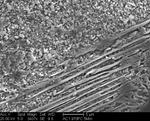
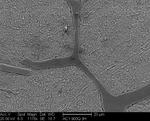
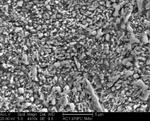
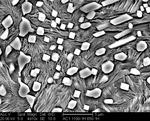
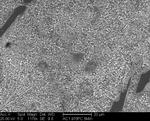

In [33]:
HTML(samples_df[['file', 'image','time (minutes)','Temperature (°C)']].to_html(formatters={'image': image_formatter}, escape=False))

## Exploring the Test Data Set:

Run the cells below to explore an interactive version of the graph found in README.md

In [34]:
test_predictions = pd.read_csv('test_dataframe.csv')


In [35]:


offset = -150

test_predictions_chart = alt.Chart(test_predictions).mark_point(color = 'orangered').encode(
    x = alt.X('delta_time', 
              axis = alt.Axis(offset = offset, title ='Time Difference (Minutes)', titleY = 175),
              scale = alt.Scale(domain=[-3000, 3000])),
              
    y = alt.Y('delta_temperature', 
              axis = alt.Axis(offset = offset,title ='Temperature Difference (K)',titleX = -175),
              scale = alt.Scale(domain=[-100, 100])),
    tooltip = [alt.Tooltip('predicted_time',title = 'Predicted Time'),
               alt.Tooltip('predicted_temperature',title = 'Predicted Temperature'),
               alt.Tooltip('true_time',title = 'True Time'),
               alt.Tooltip('true_temperature',title = 'True Temperature')]
  
).interactive()


test_predictions_chart



alt.Chart(...)